# Predictive modeling: High risk violations

## 1. Import libraries and data

In [1]:
# Data handling and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
%matplotlib inline 

## Machine learning libraries
from sklearn import datasets, metrics
from sklearn.preprocessing import LabelEncoder as le
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score,mean_absolute_error, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score, average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso

import xgboost as xgb
import missingno as msno


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
chelsea_df = pd.read_csv('chelsea_clean.csv', low_memory=False, index_col=0)

In [3]:
chelsea_all = pd.read_csv('chelsea_all.csv', low_memory = False, index_col = 0)

In [4]:
chelsea = chelsea_df.copy()
chelsea.shape

(1611, 109)

In [5]:
chelsea.head(2)

,Building Permits - Count,See Click Fix - Count,Fire Incidents - Count,Foreclosure Sales - Count,Vacant Foreclosed Properties,Property Sales - Count,Property Sales - Price,40U Violations - Count,40U Violations - Fine,Police Incidents - Count,Rat Baiting - Count,Tax Title,Total Assessed Value,Bedrooms,Building Size,Full Bathrooms,Land Size,Owner Occupied,Year Built,test parcels,Police Incidents After 2015,log_land_size,log_building_size,log_assessed_value,log_bedrooms,log_bathrooms,high_risk_violation,any_high_risk,violation_total,any_violation,overcrowding_risk,any_overcrowding_risk,APT 4-UNIT MDL-94,APT 4-UNT MDL-94,APT OVER 8 MDL-94,CHAR HOUSING C,CHAR HOUSING R,Condo NL MDL-00,Condo NL MDL-05,HOUSING AUTHORITY C,OFFICE BLD MDL-96,STORE/SHOP MDL-96,Single Fam MDL-94,TWO FAMILY MDL-94,TWO FAMILY MDL-96,Accessory Land with Improvement,Apartments with Four to Eight Units,"Dept. of Education (DOE) - UMass., State Colleges, Community Colleges",Developable Residential Land,General Office Buildings,"Housing, Other (Charitable Org.)","Mixed Use (Primarily Commercial, some Industrial)","Mixed Use (Primarily Commercial, some Residential)","Mixed Use (Primarily Residential, some Commercial)",Multiple Houses on one parcel,Other Congregate Housing (includes non-transient shared living arrangements),Rooming and Boarding Houses,Single Family Residential,Three-Family Residential,Two-Family Residential,Undevelopable Residential Land,n use,Tract 160101 Block Group 1,Tract 160101 Block Group 2,Tract 160101 Block Group 3,Tract 160101 Block Group 4,Tract 160101 Block Group 5,Tract 160200 Block Group 1,Tract 160200 Block Group 2,Tract 160200 Block Group 3,Tract 160300 Block Group 1,Tract 160300 Block Group 2,Tract 160400 Block Group 1,Tract 160400 Block Group 2,Tract 160501 Block Group 1,Tract 160501 Block Group 2,Tract 160501 Block Group 3,Tract 160501 Block Group 4,Tract 160501 Block Group 5,Tract 160502 Block Group 1,Tract 160502 Block Group 2,Tract 160502 Block Group 3,Tract 160601 Block Group 1,Tract 160601 Block Group 2,Tract 160602 Block Group 1,Tract 160602 Block Group 2,Tract 160602 Block Group 3,Tract 160602 Block Group 4,Tract 160602 Block Group 5,Tract 170100 Block Group 3,Tract 342101 Block Group 4,Tract 342600 Block Group 1,owner_occupied__0,owner_occupied__1,fuel__Coal or Wood,fuel__Electric,fuel__Gas,fuel__Oil,heat__Electr Basebrd,heat__Floor Furnace,heat__Forced Air-Duc,heat__Hot Air-no Duc,heat__Hot Water,heat__None,heat__Steam,opportunity_zone__None,opportunity_zone__Tract 160200,opportunity_zone__Tract 160400,analyze
0,0.0,0.0,0.0,0.0,0.0,1.0,260000.0,4.0,100.0,0.0,0.0,0,405500.0,4.0,3365.0,2.0,0.115141,1,1893.0,0,0.0,0.0,3.526985,5.607991,0.60206,0.30103,2.0,1.0,4.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,250.0,0.0,0.0,0,848600.0,0.0,13385.0,0.0,0.090972,0,1920.0,0,0.0,0.0,4.126618,5.928703,0.00000,0.00000,4.0,1.0,15.0,1.0,1.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.0


## 2. Prepare the data for modelling

In [6]:
# Drop predictive variables 
chelsea.drop(columns=['violation_total', 'high_risk_violation', 'any_overcrowding_risk', 'overcrowding_risk', 'any_violation'], inplace = True)

In [7]:
# Number of test and train parcels
print('The number of train parcels is ' + str(chelsea[chelsea['test parcels'] == 0].shape[0]))
print('The number of test parcels is ' + str(chelsea[chelsea['test parcels'] == 1].shape[0]))


The number of train parcels is 1263
The number of test parcels is 348


In [8]:
# Determining the train and test splits
X_train = chelsea[chelsea['test parcels'] == 0].drop(columns=['any_high_risk', 'test parcels'])
X_test = chelsea[chelsea['test parcels'] == 1].drop(columns=['any_high_risk', 'test parcels'])
y_train = chelsea[chelsea['test parcels'] == 0][['any_high_risk']]
y_test = chelsea[chelsea['test parcels'] == 1][['any_high_risk']]

In [9]:
X_train.head()

,Building Permits - Count,See Click Fix - Count,Fire Incidents - Count,Foreclosure Sales - Count,Vacant Foreclosed Properties,Property Sales - Count,Property Sales - Price,40U Violations - Count,40U Violations - Fine,Police Incidents - Count,Rat Baiting - Count,Tax Title,Total Assessed Value,Bedrooms,Building Size,Full Bathrooms,Land Size,Owner Occupied,Year Built,Police Incidents After 2015,log_land_size,log_building_size,log_assessed_value,log_bedrooms,log_bathrooms,APT 4-UNIT MDL-94,APT 4-UNT MDL-94,APT OVER 8 MDL-94,CHAR HOUSING C,CHAR HOUSING R,Condo NL MDL-00,Condo NL MDL-05,HOUSING AUTHORITY C,OFFICE BLD MDL-96,STORE/SHOP MDL-96,Single Fam MDL-94,TWO FAMILY MDL-94,TWO FAMILY MDL-96,Accessory Land with Improvement,Apartments with Four to Eight Units,"Dept. of Education (DOE) - UMass., State Colleges, Community Colleges",Developable Residential Land,General Office Buildings,"Housing, Other (Charitable Org.)","Mixed Use (Primarily Commercial, some Industrial)","Mixed Use (Primarily Commercial, some Residential)","Mixed Use (Primarily Residential, some Commercial)",Multiple Houses on one parcel,Other Congregate Housing (includes non-transient shared living arrangements),Rooming and Boarding Houses,Single Family Residential,Three-Family Residential,Two-Family Residential,Undevelopable Residential Land,n use,Tract 160101 Block Group 1,Tract 160101 Block Group 2,Tract 160101 Block Group 3,Tract 160101 Block Group 4,Tract 160101 Block Group 5,Tract 160200 Block Group 1,Tract 160200 Block Group 2,Tract 160200 Block Group 3,Tract 160300 Block Group 1,Tract 160300 Block Group 2,Tract 160400 Block Group 1,Tract 160400 Block Group 2,Tract 160501 Block Group 1,Tract 160501 Block Group 2,Tract 160501 Block Group 3,Tract 160501 Block Group 4,Tract 160501 Block Group 5,Tract 160502 Block Group 1,Tract 160502 Block Group 2,Tract 160502 Block Group 3,Tract 160601 Block Group 1,Tract 160601 Block Group 2,Tract 160602 Block Group 1,Tract 160602 Block Group 2,Tract 160602 Block Group 3,Tract 160602 Block Group 4,Tract 160602 Block Group 5,Tract 170100 Block Group 3,Tract 342101 Block Group 4,Tract 342600 Block Group 1,owner_occupied__0,owner_occupied__1,fuel__Coal or Wood,fuel__Electric,fuel__Gas,fuel__Oil,heat__Electr Basebrd,heat__Floor Furnace,heat__Forced Air-Duc,heat__Hot Air-no Duc,heat__Hot Water,heat__None,heat__Steam,opportunity_zone__None,opportunity_zone__Tract 160200,opportunity_zone__Tract 160400,analyze
0,0.0,0.0,0.0,0.0,0.0,1.0,260000.0,4.0,100.0,0.0,0.0,0,405500.0,4.0,3365.0,2.0,0.115141,1,1893.0,0.0,0.0,3.526985,5.607991,0.602060,0.301030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,250.0,0.0,0.0,0,848600.0,0.0,13385.0,0.0,0.090972,0,1920.0,0.0,0.0,4.126618,5.928703,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,750.0,2.0,1.0,0,370600.0,6.0,4180.0,3.0,0.035825,0,1900.0,1.0,0.0,3.621176,5.568905,0.778151,0.477121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,699400.0,0.0,12366.0,0.0,0.084192,0,1910.0,0.0,0.0,4.092229,5.844726,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,300000.0,5.0,100.0,1.0,0.0,0,439300.0,4.0,5197.0,4.0,0.071424,1,1890.0,1.0,0.0,3.715753,5.642761,0.602060,0.602060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.0


In [10]:
print(y_train.sum())
y_train.head()


any_high_risk    594.0
dtype: float64


,any_high_risk
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [11]:
y_test.any_high_risk.sum()

140.0

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_lasso = scaler.transform((X_train))

scaler.fit(X_test)
X_test_lasso = scaler.transform((X_test))


In [13]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1263, 102) (1263, 1)
(348, 102) (348, 1)


In [14]:
X_train_lasso

array([[-0.59221287, -0.35029821, -0.258502  , ..., -0.5066719 ,
         0.        ,  0.        ],
       [ 1.39441356, -0.35029821, -0.258502  , ...,  1.97366381,
         0.        ,  0.        ],
       [-0.59221287, -0.35029821, -0.20225945, ...,  1.97366381,
         0.        ,  0.        ],
       ...,
       [-0.59221287, -0.35029821,  0.81010653, ..., -0.5066719 ,
         0.        ,  0.        ],
       [-0.59221287, -0.35029821, -0.20225945, ..., -0.5066719 ,
         0.        ,  0.        ],
       [ 0.40110035, -0.35029821, -0.14601689, ..., -0.5066719 ,
         0.        ,  0.        ]])

## 3. Select the most appropriate model through CV

### 3.1 Random forest

In [36]:
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(average_precision_score(y_test, y_pred))
print('number predicted : ' + str(y_pred.sum())) 

0.4608713336647534
number predicted : 109.0


In [15]:
print(metrics.confusion_matrix(y_test, y_pred))


[[158  50]
 [ 81  59]]


In [48]:
# Random forest parameter tuning
forest = RandomForestClassifier(random_state = 1)

n_estimators = [100, 300, 500]
max_depth = [1, 2, 5, 8, 15, 25]
min_samples_split = [2, 5, 10, 100]
min_samples_leaf = [1, 2, 5, 10] 
max_features = ["log2", "sqrt"]
criterion = ["gini", "entropy"] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, max_features = max_features, criterion=criterion)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring='average_precision')
bestF = gridF.fit(X_train, y_train)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 36.3min finished


In [49]:
print(gridF.best_params_)
print(gridF.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.6541046859664749


In [50]:
# Second grid search
n_estimators = [400, 500, 600]
max_depth = [13, 15, 17]
min_samples_split = [1.0, 2, 3, 4]
min_samples_leaf = [1]
criterion = ['gini']
max_features = ['sqrt']

hyperF2 = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, criterion=criterion, max_features=max_features)

gridF2 = GridSearchCV(forest, hyperF2, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring='average_precision')
bestF2 = gridF2.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


In [51]:
print(gridF2.best_params_)
print(gridF2.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.6541046859664749


In [52]:
# Third grid search
n_estimators = [450, 500, 550]
max_depth = [14, 15, 16]
min_samples_split = [2]
min_samples_leaf = [1]
criterion = ['gini']
max_features = ['sqrt']

hyperF3 = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, criterion=criterion, max_features=max_features)

gridF3 = GridSearchCV(forest, hyperF3, cv = 5, verbose = 1, 
                      n_jobs = -1, scoring='average_precision')
bestF3 = gridF3.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.7s finished


In [53]:
print(gridF3.best_params_)
print(gridF3.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550}
0.6542779298408757


In [15]:
random_forest = RandomForestClassifier(max_depth = 15, n_estimators=550, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='gini', random_state=1)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
acc_random_forest = average_precision_score(y_test, y_pred)
print(acc_random_forest)
print('number predicted : ' + str(y_pred.sum())) 

0.4631614885626494
number predicted : 101.0


### 3.2 XGBoost

In [16]:
xgb_model=xgb.XGBClassifier(random_state=1)
xgb_model.fit(X_train, y_train)

y_pred2 = xgb_model.predict(X_test)
xgb_score = average_precision_score(y_test, y_pred)
print(xgb_score)
print('number predicted: ' + str(y_pred.sum()))

0.4631614885626494
number predicted: 101.0


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [56]:
print(metrics.confusion_matrix(y_test, y_pred2))

[[155  53]
 [ 81  59]]


In [57]:
hyperB1 = {"n_estimators" : range(50, 400, 50),
          "learning_rate" : [0.05, 0.1, 0.3]}

gridB1 = GridSearchCV(xgb_model, hyperB1, cv = 5, verbose = 1, scoring='average_precision', n_jobs = -1)
bestB1 = gridB1.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.1min finished


In [58]:
print(gridB1.best_params_)
print(gridB1.best_score_)

{'learning_rate': 0.05, 'n_estimators': 50}
0.623302058788627


In [59]:
# Update these
hyperB2 = {"n_estimators" :  range(25, 125, 25),
          "learning_rate" : [0.05, 0.1, 0.3]}

gridB2 = GridSearchCV(xgb_model, hyperB2, cv = 5, verbose = 1, n_jobs = -1, scoring='average_precision')
bestB2 = gridB2.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.6s finished


In [60]:
print(gridB2.best_params_)
print(gridB2.best_score_)

{'learning_rate': 0.05, 'n_estimators': 75}
0.6242937736381609


In [61]:
hyperB3 = {"learning_rate"    : [0.05] ,
          'n_estimators'     : [75],
 "max_depth"        : [ 1, 3, 4, 6, 8, 10, 15],  
 "min_child_weight" : [ 1, 3, 5, 7],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.4],
 "colsample_bytree" : [ 0.3, 0.5, 0.7, 1],
  "subsample"       : [0.5, 0.75, 1]}

gridB3 = GridSearchCV(xgb_model, hyperB3, cv = 5, n_jobs = -1, verbose = 1, scoring='average_precision')
bestB3 = gridB3.fit(X_train, y_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed: 26.7min finished


In [62]:
print(gridB3.best_params_)
print(gridB3.best_score_)

{'colsample_bytree': 0.5, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.5}
0.6398794426639193


In [63]:
hyperB4 = {"learning_rate"    : [0.3] ,
          'n_estimators'     : [75],
 "max_depth"        : [12, 15, 20, 25],  
 "min_child_weight" : [1, 2],
 "gamma"            : [0.2, 0.3],
 "colsample_bytree" : [0.4, 0.5, 0.6],
  "subsample"       : [0.5]}

gridB4 = GridSearchCV(xgb_model, hyperB4, cv = 5, n_jobs = -1, verbose = 1, scoring='average_precision')
bestB4 = gridB4.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


In [64]:
print(gridB4.best_params_)
print(gridB4.best_score_)

{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.5}
0.6104576925637833


In [65]:
hyperB5 = {
 "learning_rate"    : [0.3] ,
 'n_estimators'     : [75],
 "max_depth"        : [12],  
 "min_child_weight" : [1],
 "gamma"            : [0.3],
 "colsample_bytree" : [0.6], 
 "subsample"        : [0.5],
 "lambda"           : [0.3, 0.5, 0.7, 1],
 "alpha"            : [0.3, 0.5, 0.7, 1]
}

gridB5 = GridSearchCV(xgb_model, hyperB5, cv = 5, verbose = 1, scoring='average_precision', n_jobs = -1)
bestB5 = gridB5.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   37.1s finished


In [66]:
print(gridB5.best_params_)
print(gridB5.best_score_)

{'alpha': 0.3, 'colsample_bytree': 0.6, 'gamma': 0.3, 'lambda': 0.3, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 75, 'subsample': 0.5}
0.6104576925637833


In [17]:
xgb_model = xgb.XGBClassifier(
    n_estimators = 75, 
    max_depth = 12, 
    min_child_weight = 1, 
    colsample_bytree = 0.6, 
    subsample = 0.5,
    gamma = 0.3, 
    alpha = 0.3,
    reg_lambda = 0.3,
    learning_rate = 0.01,
    random_state=1)
xgb_model.fit(X_train, y_train)
y_pred2 = xgb_model.predict(X_test)
acc_xgb = average_precision_score(y_test, y_pred2)
print(acc_xgb)
print('number predicted : ' + str(y_pred2.sum())) 

0.4832026843720997
number predicted : 115.0


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 3.3 LASSO

In [18]:
# Fitting the LASSO with the lambda found by CV
lasso = Lasso()
lasso.fit(X_train_lasso, y_train)
lasso_pred = lasso.predict((X_test_lasso))
lasso_pred = np.where(lasso_pred > 0.5, 1, 0)
lasso_pred = pd.DataFrame(lasso_pred)
print(average_precision_score(y_test, lasso_pred))
print('number predicted : ' + str(lasso_pred.sum()[0])) 

0.40229885057471265
number predicted : 0


In [19]:
# LASSO parameter tuning
# https://towardsdatascience.com/lasso-regression-tutorial-fd68de0aa2a2


# First iteration

alpha = np.linspace(0.00001,0.15,30)
best_i = []
best_i_score = 0


for i in alpha:
    lasso = Lasso(alpha = i)
    kf = KFold(n_splits=5)
    kf_scoring = []
    for train_index, test_index in kf.split(X_train_lasso):
        X_train_kf, X_test_kf = X_train_lasso[train_index], X_train_lasso[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
        lasso.fit(X_train_kf, y_train_kf)
        lasso_pred = lasso.predict(X_test_kf)
        lasso_pred = np.where(lasso_pred > 0.5, 1, 0)
        lasso_pred = pd.DataFrame(lasso_pred)
        kf_scoring.append(average_precision_score(y_test_kf, lasso_pred)*100)
    print(str(round(i,5)) + ' ' +  str(np.mean(kf_scoring)))
    if np.mean(kf_scoring) > best_i_score:
        best_i = i
        best_i_score = np.mean(kf_scoring)

print('The best possible lambda, based on 5-fold CV is: ' + str(best_i))

1e-05 55.18085138193985
0.00518 55.25167144184381
0.01035 55.08728790733484
0.01553 54.29100235781552
0.0207 54.31517176593538
0.02587 54.22930812398319
0.03104 53.59368426007302
0.03621 52.25375553534551
0.04139 51.771192019146554
0.04656 51.74251009743379
0.05173 51.01888075412506
0.0569 50.89982834624083
0.06207 50.927955308400776
0.06725 50.927955308400776
0.07242 48.37844676794582
0.07759 48.37844676794582
0.08276 47.60041902141413
0.08794 47.60041902141413
0.09311 47.60041902141413
0.09828 47.237610914977836
0.10345 47.02992659514398
0.10862 47.02992659514398
0.1138 47.02992659514398
0.11897 47.02992659514398
0.12414 47.02992659514398
0.12931 47.02992659514398
0.13448 47.02992659514398
0.13966 47.02992659514398
0.14483 47.02992659514398
0.15 47.02992659514398
The best possible lambda, based on 5-fold CV is: 0.0051820689655172406


In [20]:
# Second iteration

alpha = np.linspace(0.0000001,0.001,30)

for i in alpha:
    lasso = Lasso(alpha = i)
    kf = KFold(n_splits=5)
    kf_scoring = []
    for train_index, test_index in kf.split(X_train_lasso):
        X_train_kf, X_test_kf = X_train_lasso[train_index], X_train_lasso[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
        lasso.fit(X_train_kf, y_train_kf)
        lasso_pred = lasso.predict(X_test_kf)
        lasso_pred = np.where(lasso_pred > 0.5, 1, 0)
        lasso_pred = pd.DataFrame(lasso_pred)
        kf_scoring.append(average_precision_score(y_test_kf, lasso_pred)*100)
    print(str(round(i,5)) + ' - ' +  str(np.mean(kf_scoring)))
    if np.mean(kf_scoring) > best_i_score:
        best_i = i
        best_i_score = np.mean(kf_scoring)

print('The best possible lambda, based on 5-fold CV is: ' + str(best_i))

0.0 - 55.18085138193985
3e-05 - 55.18085138193985
7e-05 - 55.25068546357003
0.0001 - 55.19439789681722
0.00014 - 55.19439789681722
0.00017 - 55.32143912485676
0.00021 - 55.39206724284179
0.00024 - 55.39206724284179
0.00028 - 55.32063069609205
0.00031 - 55.25835930381472
0.00034 - 55.18727144688653
0.00038 - 55.25835930381472
0.00041 - 55.25835930381472
0.00045 - 55.25835930381472
0.00048 - 55.25349748060362
0.00052 - 55.32028340785466
0.00055 - 55.32028340785466
0.00059 - 55.382075413768064
0.00062 - 55.32186300056336
0.00066 - 55.24788918082684
0.00069 - 55.305241086390154
0.00072 - 55.37250806864237
0.00076 - 55.242661424969675
0.00079 - 55.242661424969675
0.00083 - 55.25041116140363
0.00086 - 55.25041116140363
0.0009 - 55.32574229893349
0.00093 - 55.39196638223607
0.00097 - 55.4496080465791
0.001 - 55.52633420517433
The best possible lambda, based on 5-fold CV is: 0.001


In [21]:
# Fitting the LASSO with the lambda found by CV
lasso = Lasso(alpha = best_i)
lasso.fit(X_train_lasso, y_train)
lasso_pred = lasso.predict((X_test_lasso))
lasso_pred = np.where(lasso_pred > 0.5, 1, 0)
lasso_pred = pd.DataFrame(lasso_pred)
lasso_score = average_precision_score(y_test, lasso_pred)
print(lasso_score)
print('number predicted : ' + str(lasso_pred[0].sum())) 

0.4420054028285396
number predicted : 155


## 4. Comparing all the models

In [22]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Lasso'],
    'Score': [acc_random_forest, acc_xgb, lasso_score]
    })
models.sort_values(by='Score', ascending=False)

,Model,Score
1,XGBoost,0.483203
0,Random Forest,0.463161
2,Lasso,0.442005


In [23]:
# Create a function for quick summary of the relevant metrics

def summary(y_test, y_pred, model_name = ''):
    confusion_matrix = (metrics.confusion_matrix(y_test, y_pred))
    ave_precision = average_precision_score(y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    #ppv = confusion_matrix[0,0] / ()
    #npv = confusion_matrix[0,1]
    print(model_name + '\n')
    print(str(confusion_matrix) + '\n')
    print('Average Precision Score: ' + str(round(ave_precision, 2)))
    print('Accuracy: ' + str(round(acc, 2)))
    print('Recall (tp/tp+fn): ' + str(round(recall, 2)))
    print('Precision (tp/tp+fp): ' + str(round(precision, 2)))
    print('F1 score: ' + str(round(f1, 2)))
    
    print('\n')


In [24]:
summary(y_test, y_pred2, model_name='XGBoost')
summary(y_test, y_pred, model_name='Random Forest')
summary(y_test, lasso_pred, model_name='LASSO')

XGBoost

[[159  49]
 [ 74  66]]

Average Precision Score: 0.48
Accuracy: 0.65
Recall (tp/tp+fn): 0.47
Precision (tp/tp+fp): 0.57
F1 score: 0.52


Random Forest

[[163  45]
 [ 84  56]]

Average Precision Score: 0.46
Accuracy: 0.63
Recall (tp/tp+fn): 0.4
Precision (tp/tp+fp): 0.55
F1 score: 0.46


LASSO

[[127  81]
 [ 66  74]]

Average Precision Score: 0.44
Accuracy: 0.58
Recall (tp/tp+fn): 0.53
Precision (tp/tp+fp): 0.48
F1 score: 0.5




LASSO: ROC AUC=0.626
XGBoost: ROC AUC=0.678
Random Forest: ROC AUC=0.679
No Skill: ROC AUC=0.500


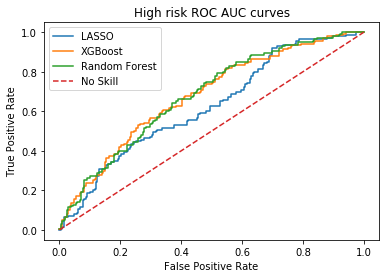

In [25]:
# roc-auc
ns_probs = [0 for _ in range(len(y_test))]
rf_probs = random_forest.predict_proba(X_test)
rf_probs = rf_probs[:,1]
xgb_probs = xgb_model.predict_proba(X_test)
xgb_probs = xgb_probs[:, 1]
lasso_probs = lasso.predict(X_test_lasso)


lasso_auc = roc_auc_score(y_test, lasso_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
ns_auc = roc_auc_score(y_test, ns_probs)


print('LASSO: ROC AUC=%.3f' % (lasso_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('No Skill: ROC AUC=%.3f' % (ns_auc))


lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_probs)
plt.plot(lasso_fpr, lasso_tpr, label='LASSO')

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, label='Random Forest')

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('High risk ROC AUC curves')

plt.savefig('High risk - AUC ROC.png')


plt.show()




C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost: f1=0.518 auc=0.565
Random Forest: f1=0.465 auc=0.562
LASSO: f1=0.575 auc=0.504


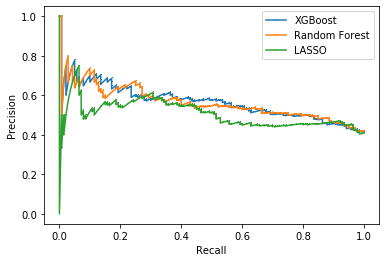

In [26]:
# predict xgboost class values
xgb_probs = xgb_model.predict_proba(X_test)
xgb_probs = xgb_probs[:,1]
yhat = xgb_model.predict(X_test)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test, yhat), auc(xgb_recall, xgb_precision)


# predict random forest class values
rf_probs = random_forest.predict_proba(X_test)
rf_probs = rf_probs[:,1]
yhat = random_forest.predict(X_test)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_f1, rf_auc = f1_score(y_test, yhat), auc(rf_recall, rf_precision)


# predict LASSO class values
lasso_probs = lasso.predict(X_test_lasso)
yhat = lasso.predict(X_test)
yhat = np.where(yhat > 0.5, 1, 0)
lasso_precision, lasso_recall, _ = precision_recall_curve(y_test, lasso_probs)
lasso_f1, lasso_auc = f1_score(y_test, yhat), auc(lasso_recall, lasso_precision)




print('XGBoost: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))
print('LASSO: f1=%.3f auc=%.3f' % (lasso_f1, lasso_auc))

plt.plot(xgb_recall, xgb_precision, marker=',', label='XGBoost')
plt.plot(rf_recall, rf_precision, marker=',', label='Random Forest')
plt.plot(lasso_recall, lasso_precision, marker=',', label='LASSO')



# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')


# show the legend
plt.legend()

plt.savefig('High risk - Precision Recall AUC.png')

# show the plot
plt.show()

## 5. Display the feature importances

In [28]:
xgb_feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
xgb_feature_importances.head(20)

,importance
Tract 160101 Block Group 5,0.051735
Condo NL MDL-05,0.046304
Tract 160501 Block Group 2,0.032077
APT 4-UNT MDL-94,0.028946
heat__Steam,0.025094
Tract 160502 Block Group 3,0.024519
n use,0.024240
opportunity_zone__None,0.023925
Tract 160101 Block Group 4,0.023181
Tract 160101 Block Group 2,0.021499


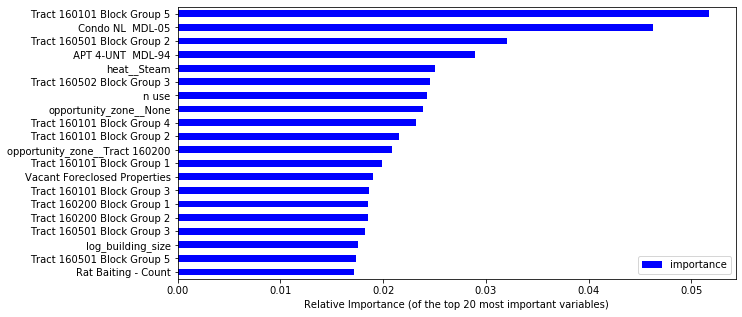

In [29]:
xgb_importances = xgb_feature_importances[:20].iloc[::-1]
xgb_importances.plot.barh(color='b', align='center', figsize=(10,5))
ax = plt.xlabel('Relative Importance (of the top 20 most important variables)')

plt.savefig('High risk - Feature importances')

## Exporting

In [31]:
chelsea_all_predict = chelsea_all.drop(columns=['Parcel ID', 'Address', 'Target Area', 'any_coh'])
chelsea_all_predict.head(2)


In [ ]:
final_predictions = pd.DataFrame(xgb_model.predict_proba(chelsea_all_predict.drop(columns=['violation_total', 'high_risk_violation', 'any_high_risk', 'overcrowding_risk', 'any_violation', 'test parcels', 'any_overcrowding_risk'])))
chelsea_all['probability of high risk'] = final_predictions[1]
chelsea_all[['Parcel ID', 'Address', 'probability of overcrowding']].to_csv('final_predictions_high_risk.csv')